In [1]:
%load_ext autoreload

In [2]:
%autoreload
from mine.models.mine import Mine
import torch.nn as nn
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import ceil

Device: cuda


In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224//5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 1000


# USE 100K TEST DATA
dataset = torchvision.datasets.ImageFolder(
    root='/scratch/network/ls1546/imagenet/ILSVRC/Data/CLS-LOC/test', 
    transform=transform
)

# # load part of dataset
# indices = torch.arange(20000)
# dataset_half = torch.utils.data.Subset(dataset, indices)
# dataloader = torch.utils.data.DataLoader(dataset_half, batch_size=batch_size, shuffle=True, num_workers=2)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

cuda:1


In [15]:
# image_dim = 224//5*224//5*3
image_dim = 224//5
mask_size = 5
weights1 = torch.zeros((image_dim, image_dim))
weights1[ceil(image_dim/2-mask_size/2):ceil(image_dim/2+mask_size/2), ceil(image_dim/2-mask_size/2):ceil(image_dim/2+mask_size/2)] = 3

weights2 = torch.zeros((image_dim, image_dim))
weights2[:5, :5] = 3

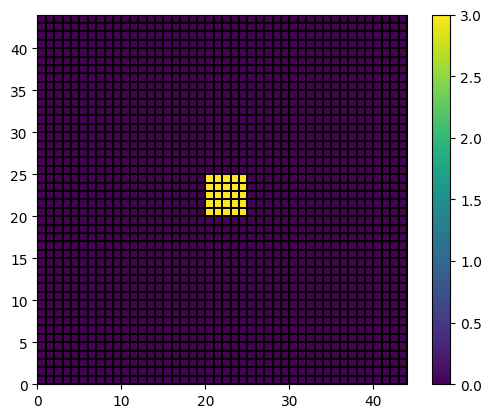

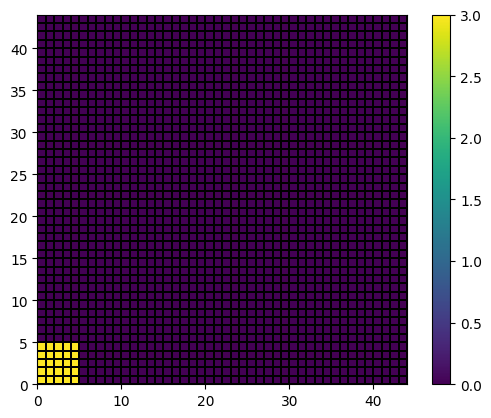

In [16]:
plt.figure()
plt.pcolormesh(weights1, edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(weights2, edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.show()

In [24]:
flat_weights1 = torch.flatten(weights1)
flat_weights1 = torch.cat((flat_weights1, flat_weights1, flat_weights1), dim=-1)
flat_weights1 = torch.unsqueeze(flat_weights1, 0)

flat_weights2 = torch.flatten(weights2)
flat_weights2 = torch.cat((flat_weights2, flat_weights2, flat_weights2), dim=-1)
flat_weights2 = torch.unsqueeze(flat_weights2, 0)

flat_weights = torch.cat((flat_weights1, flat_weights2), dim=0)
flat_weights.shape

torch.Size([2, 5808])

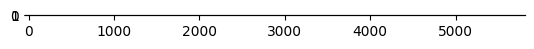

In [49]:
plt.imshow(torch.reshape(flat_weights, ())

In [25]:
# pass images through toy_network to get activations
class Toynetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(image_dim*image_dim*3, 2)
        self.fc1.weight = torch.nn.Parameter(flat_weights)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        y = F.relu(self.fc2(input))
        return x + y 

In [26]:
toy_net = Toynetwork().to(device)

In [27]:
# add hooks, run model with inputs to get activations

# a dict to store the activations
activation = {}
def get_activation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach().cpu().numpy()
        # activation[name] = output.numpy()
    return hook

hook = toy_net.fc1.register_forward_hook(get_activation('fc1'))

In [28]:
inputs_list = []
act_list = []

for inputs, _ in tqdm(dataloader):
    inputs = torch.flatten(inputs, start_dim=1)
    inputs = inputs.to(device)

    with torch.no_grad():
        output = toy_net(inputs)
        
        # collect the activations
        act_list.append(activation['fc1'])

        inputs = inputs.detach().cpu().numpy()
        inputs_list.append(inputs)

    del inputs

# detach the hooks
hook.remove()

100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


In [29]:
act_length = (len(act_list) - 1)*batch_size + len(act_list[len(act_list)-1])
act_length, len(act_list), act_list[0].shape, inputs_list[0].shape, inputs_list[-1].shape

(100000, 100, (1000, 2), (1000, 5808), (1000, 5808))

In [30]:
def scale_rgb(x):
    return ((x - x.min()) / (x.max() - x.min()))

array([[[0.4585366 , 0.590244  , 0.7268293 , ..., 0.27317074,
         0.595122  , 0.33170736],
        [0.2878049 , 0.2780488 , 0.23414633, ..., 0.1317073 ,
         0.39512196, 0.4780488 ],
        [0.26341465, 0.26341465, 0.07804877, ..., 0.3609756 ,
         0.6585366 , 0.595122  ],
        ...,
        [0.7317074 , 0.7268293 , 0.7219513 , ..., 0.39512196,
         0.7073172 , 0.76097566],
        [0.7219513 , 0.7317074 , 0.7463415 , ..., 0.5804879 ,
         0.71219516, 0.7317074 ],
        [0.70243907, 0.7268293 , 0.7463415 , ..., 0.5121951 ,
         0.6487805 , 0.71219516]],

       [[0.3960396 , 0.52970296, 0.6782178 , ..., 0.22277227,
         0.56435645, 0.29702973],
        [0.25247526, 0.24257426, 0.21782178, ..., 0.06435643,
         0.34158418, 0.42574257],
        [0.24257426, 0.24752475, 0.06930692, ..., 0.28712875,
         0.59900993, 0.5346534 ],
        ...,
        [0.82673264, 0.8217822 , 0.8168317 , ..., 0.31683168,
         0.6386139 , 0.6881189 ],
        [0.8

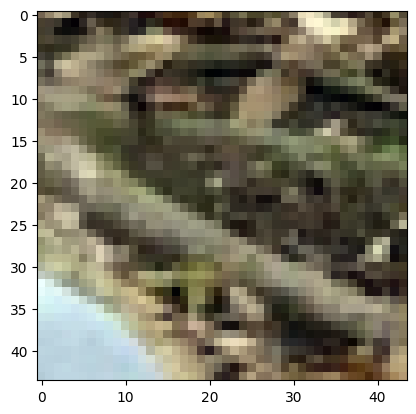

In [31]:
x = inputs_list[-1].copy()
x = np.reshape(x[-1], (3, 44, 44))
x[0] = scale_rgb(x[0])
x[1] = scale_rgb(x[1])
x[2] = scale_rgb(x[2])
plt.imshow(np.transpose(x, (1,2,0)))
x

In [37]:
y = act_list[-1].copy()
y[-1]

array([-202.63026, -213.22838], dtype=float32)

In [38]:
samples = (len(inputs_list) - 1)*batch_size + len(inputs_list[len(inputs_list)-1])
images_flat = np.zeros((samples, (224//5)*(224//5)*3))
responses = np.zeros((act_length, 2))
x_dim=(224//5)*(224//5)*3
y_dim=2

for batch in range(len(act_list)):
    for image in range(len(act_list[batch])):
        responses[batch*len(act_list[0])+image, :] = act_list[batch][image, :]
        images_flat[batch*len(act_list[0])+image, :] = inputs_list[batch][image].flatten()

In [39]:
samples, act_length

(100000, 100000)

In [40]:
del act_list, inputs_list

In [41]:
class Image_network(nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.fc1x = nn.Linear(x_dim, 2, bias=False)
        self.fc1y = nn.Linear(y_dim, 2, bias=False)
        self.fc2 = nn.Linear(4, 100, bias=False)
        self.fc3 = nn.Linear(100, 1, bias=False)

    def forward(self, x, y):
        x = F.relu(self.fc1x(x))
        y = F.relu(self.fc1y(y))
        h = torch.cat((x, y), dim=1)
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

In [42]:
torch.tensor(images_flat, dtype=torch.float32).to(device)

tensor([[ 0.9303,  0.9646,  0.9817,  ..., -1.8044, -1.8044, -1.8044],
        [ 0.9303,  0.8276,  0.7933,  ...,  0.6356,  0.3916, -1.1421],
        [-0.7822, -0.8335, -0.3712,  ..., -0.7936, -0.0964,  0.7751],
        ...,
        [-1.1589, -1.3302, -1.6898,  ..., -1.0027, -1.1770, -1.1596],
        [-0.9534, -0.9877, -1.0219,  ..., -1.2119, -1.4733, -1.6650],
        [-0.2684,  0.1939,  0.6734,  ..., -0.6541, -0.2881,  0.1128]],
       device='cuda:1')

In [ ]:
mine = Mine(
    T=Image_network(x_dim, y_dim),
    loss="mine",  # mine_biased, fdiv
).to(device)
lam = 0.005
mi, loss_log = mine.optimize(torch.tensor(images_flat, dtype=torch.float32).to(device), torch.tensor(responses, dtype=torch.float32).to(device), 1000, batch_size, lam)

In [44]:
lam_str = str(lam)
torch.save(mine.T, "mineT2shapes" + lam_str + ".pth")
np.save("mi2shapes" + lam_str + ".npy", mi.detach().cpu().numpy())
np.save("loss2shapes" + lam_str + ".npy", torch.stack(loss_log).detach().cpu().numpy())

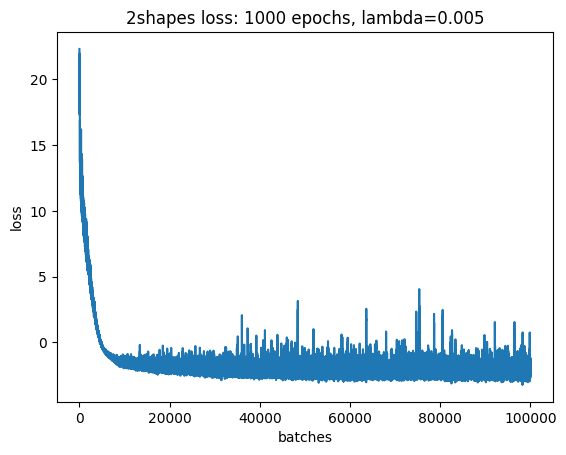

In [45]:
plt.figure()
plt.plot(torch.stack(loss_log).detach().cpu().numpy())
plt.title("2shapes loss: 1000 epochs, lambda=" + lam_str)
plt.ylabel("loss")
plt.xlabel("batches")
plt.savefig("loss2shapes" + lam_str+".pdf")

In [60]:
Tweights = mine.T.fc1x.weight.detach().cpu().numpy()[1]
Tweights.shape
unflat_Tweights = np.reshape(Tweights, (3, 224 // 5, 224 // 5))

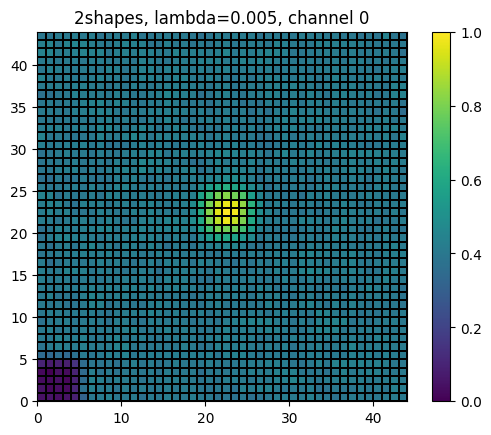

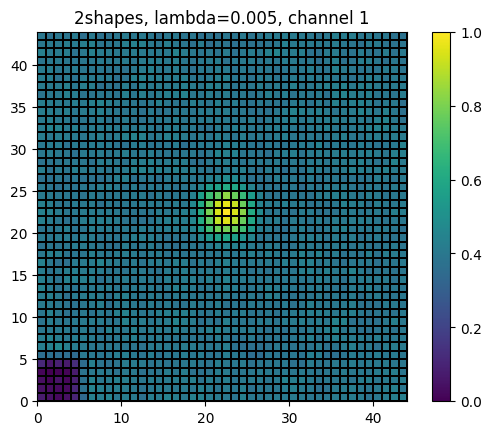

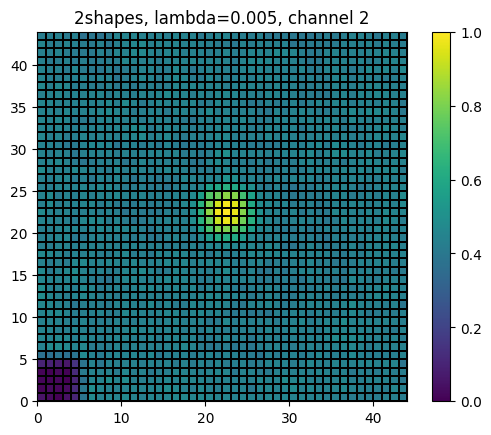

In [61]:
for i in range(3):
    # plt.clf()
    plt.figure()
    plt.pcolormesh(scale_rgb(unflat_Tweights[i]), edgecolors="k", linewidth=0.005)
    ax = plt.gca()
    ax.set_aspect("equal")
    plt.colorbar()
    plt.title(f"2shapes, lambda={lam_str}, channel {i}")
    # plt.savefig(f"Tweightsc{i}{lam_str}2shapes.pdf")
    plt.show()

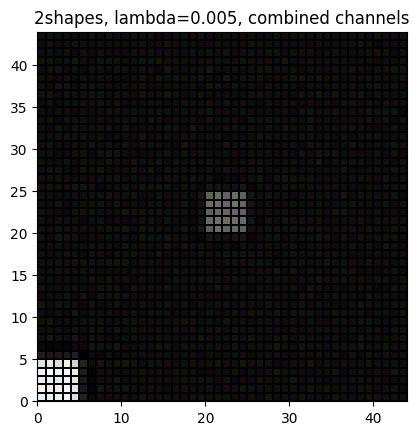

In [48]:
plt.figure()
plt.pcolormesh(
    np.transpose(np.array(list(map(scale_rgb, unflat_Tweights))), (1, 2, 0)),
    edgecolors="k",
    linewidth=0.005,
)
plt.title(f"2shapes, lambda={lam_str}, combined channels")
ax = plt.gca()
ax.set_aspect("equal")
# plt.savefig("Tweightscomb" + lam_str + "2shapes.pdf")
plt.show()

ValueError: For X (45) and Y (4) with flat shading, A should have shape (3, 44, 3) or (3, 44, 4) or (3, 44) or (132,), not (3, 44, 44)

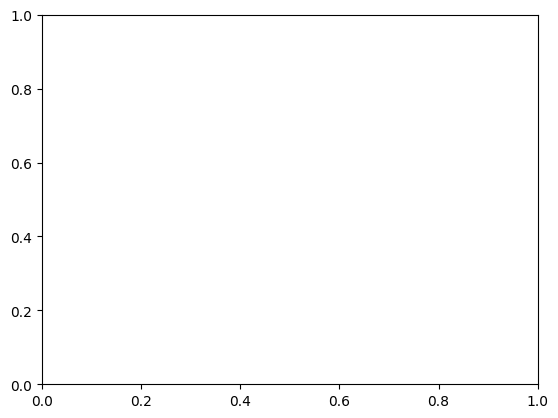

In [54]:
plt.figure()
plt.pcolormesh(
    torch.reshape(flat_weights[0], (3, 224 // 5, 224 // 5)),
    edgecolors="k",
    linewidth=0.005,
)
# plt.title(f"2shapes, lambda={lam_str}, combined channels")
ax = plt.gca()
ax.set_aspect("equal")
# plt.savefig("Tweightscomb" + lam_str + "2shapes.pdf")
plt.show()